In [1]:
import os
from os.path import exists
import torch
import torch.nn as nn
from torch.nn.functional import log_softmax, pad
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets as datasets
import spacy
import warnings
from torch.utils.data.distributed import DistributedSampler
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.nn.parallel import DistributedDataParallel as DDP


# Set to False to skip notebook execution (e.g. for debugging)
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
warnings.filterwarnings("ignore")

d:\ProgramData\Anaconda3\envs\py38\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


绝大多数序列处理模型都是 **encoder-decoder** 的结构。首先,encoder部分将输入序列$(x_1,...,x_n)$映射到一系列对输入的表征序列 $z = (z_1,...,z_n)$中。Decoder部分是使用输入的表征序列$z$，来生成输出序列$(y_1,...,y_m)$.在每一步，该模型都是自回归模型，在生成下一个符号时，将之前生成的符号作为额外的输入。

In [2]:
class EncoderDecoder(nn.Module):
    """
    标准的encoder-decoder结构
    """

    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

class Generator(nn.Module):
    "Decoder后的生成输出序列的模块"

    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return log_softmax(self.proj(x), dim=-1)

![def](./transformer.png)

In [3]:
# Transformer中encoder, decoder都是由相同结构的layer 组成的，所以这个函数用来重复相同的layer
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

### Attention 

注意力机制可以被描述为将一个query和一组key-value对映射到一个输出，其中query、key、value和输出都是向量。输出是数值的加权和，其中分配给每个数值的权重是由query与相应的key的相关性函数计算的。
$$
Attention(Q,K,V) = softmax(\frac{QK^T}{\sqrt{d_k}})V
$$

In [13]:
def attention(query, key, value, mask = None, dropout = None):
    "Compute Scalued Dot Product Attention"
    d_k = query.size(-1)  # 64
    scores = torch.matmul(query, key.transpose(-2,-1)) / math.sqrt(d_k)
    # print(scores.shape)
    if mask is not None:
        # 对于encoder的self attention以及decoder的cross attention只考虑sequence有内容的，不考虑是padding
        # 对于decoder的self attention 还需要mask掉当前step之后的词
        scores = scores.masked_fill(mask == 0, -1e-9)  
    
    p_attn = scores.softmax(dim = -1)
    # print(p_attn.shape)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [15]:
# 例子
q = torch.randn(2,127,512)
k = torch.randn(2,127,512)
v = torch.randn(2,127,512)
output, _ = attention(q,k,v)
# 其中attention 中的scores 维度为[2, 127, 127], 表示的是127个词互相之间的attenton scores
print(output.shape)

torch.Size([2, 127, 512])


### MultiHead Attention
$$
\begin{array}{c}
\text { MultiHead }(Q, K, V)=\operatorname{Concat}\left(\operatorname{head}_{1}, \ldots, \operatorname{head}_{\mathrm{h}}\right) W^{O} \\
\text { where head }{ }_{\mathrm{i}}=\operatorname{Attention}\left(Q W_{i}^{Q}, K W_{i}^{K}, V W_{i}^{V}\right)
\end{array}
$$
其中多头的个数必须要能够整除模型的hidden states size。比如，使用$h=8$，每个头的$d_k=d_v=d_{model}/h = 64$.

In [17]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout = 0.1):
        super().__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p = dropout)
    
    def forward(self, query, key, value, mask = None):
        if mask is not None:
            mask = mask.unsqueeze(1)  # 这里是为了多头注意力机制，新增一维度 （bs, num_head, ...）
        # print(mask.shape) # 一般的src mask: torch.Size([bs, 1, 1, squence_length])  tgt mask: torch.Size([bs, 1, squence_length, squence_length])

        nbatches = query.size(0)

        # 1) 首先对Q,K,V进行一次线性变换,然后将d_model --> h x d_k
        query = self.linears[0](query).view(nbatches, -1, self.h, self.d_k).transpose(1,2)  # torch.Size([bs, 1, squence_length, d_model // h])  d_model // h 一般为 512 // 8 = 64
        key = self.linears[1](key).view(nbatches, -1, self.h, self.d_k).transpose(1,2)  
        value = self.linears[2](value).view(nbatches, -1, self.h, self.d_k).transpose(1,2)  

        # 2) apply attention
        x, self.attn = attention(
            query, key, value, mask=mask, dropout=self.dropout
        )

        # 3) h x d_k --> d_model
        x = x.transpose(1,2).contiguous().view(nbatches, -1, self.h * self.d_k)
        del query
        del key
        del value
        return self.linears[-1](x)


In [18]:
# test example
MHattention = MultiHeadedAttention(8, 512)
q = torch.randn(2,127,512)
k = torch.randn(2,127,512)
v = torch.randn(2,127,512)
MHattention(q,k,v).shape

torch.Size([2, 127, 512])

Multi-Head Attention在Transformer中有三处使用了 
1) "encoder-decoder attention"，queries来自前一个decoder layer，而keys和values来自encoder的输出。这使得decoder中的每个输出都能关注到输入序列中的所有位置。 

2) encoder包含self-attention layers。在self-attention layers，所有的queries, keys, values都来自encoder中前一层的输出。encoder中的每个位置都可以关注到encoder前一层的所有位置。 

3) decoder中的self-attention layers允许decoder关注直到并包括该位置的所有信息。我们需要防止decoder中的信息向左流动，以保持自动回归的特性。

### Position-wise Feed-Forward Networks
在encoder和decoder中，每个attention based 层后都接有一个fully connected feed-forward 网络。它由两层线性层和ReLU激活函数组成。
$$
FFN(x) = ReLU(xW_1+b_1)W_2+b_2
$$

In [19]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.w_2(self.relu(self.dropout(self.w_1(x))))

### Residue Connection
每一层的输出都采用了residule connection的形式，同时也使用了Layer Normalization。
$$
Opt = LayerNorm(x+Sublayer(x))
$$


In [20]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details). Now, we can use nn.LayerNorm to do this job"

    def __init__(self, features, eps=1e-6):
        super().__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
    
    def forward(self, x):
        mean = x.mean(-1, keepdim = True)
        std = x.std(-1, keepdim = True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2 

class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    """
    def __init__(self, size, dropout):
        super().__init__()
        self.norm = nn.LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x, sublayer):
        return self.norm(x + self.dropout(sublayer(x)))

### Encoder Layer
每一个EncoderLayer都包含两层layer，第一个是multi-head self-attention mechanism,第二个是positional-wise fully connected feed-forward network.

In [21]:
class EncoderLayer(nn.Module):

    def __init__(self, size, self_attn, feed_forward, dropout):
        super().__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size
    
    def forward(self, x, mask):

        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

# Encoder
Encoder是由几个encoder layer构成的。

In [22]:
class Encoder(nn.Module):

    def __init__(self, layer, N):
        super().__init__()
        self.layers = clones(layer, N)
        self.norm = nn.LayerNorm(layer.size)
    
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        
        return self.norm(x)

### Decoder Layer
Decoder layer 比 encoder layer 多一层与encoder layer交互的cross attention。

In [23]:
class DecoderLayer(nn.Module):

    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super().__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        # print(f'x: {x.shape}')  # [batch, seq_len-1, 512] 
        # print(f'memory: {memory.shape}') # [batch, seq_len, 512]
        # print(f'src_mask: {src_mask.shape}')  # [batch, 1, seq_len]
        # print(f'tgt_mask: {tgt_mask.shape}')  # [batch, seq_len-1, seq_len]
        m = memory # 这是从encoder来的key, value
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [24]:
class Decoder(nn.Module):

    def __init__(self, layer, N):
        super().__init__()
        self.layers = clones(layer, N)
        self.norm = nn.LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)

### tgt mask
我们还修改了decoder中的self attention，在其中加入了mask，为了防止当前模型能够获得当前step之后的序列信息。这种屏蔽，确保对位置i的预测只取决于小于i的位置的已知输出。

In [25]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(
        torch.uint8
    )
    return subsequent_mask == 0

In [26]:
subsequent_mask(10)

tensor([[[ True, False, False, False, False, False, False, False, False, False],
         [ True,  True, False, False, False, False, False, False, False, False],
         [ True,  True,  True, False, False, False, False, False, False, False],
         [ True,  True,  True,  True, False, False, False, False, False, False],
         [ True,  True,  True,  True,  True, False, False, False, False, False],
         [ True,  True,  True,  True,  True,  True, False, False, False, False],
         [ True,  True,  True,  True,  True,  True,  True, False, False, False],
         [ True,  True,  True,  True,  True,  True,  True,  True, False, False],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True, False],
         [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True]]])

### Mask in Transformer
这里着重讲解一下transformer中的几个mask。

1. src_mask \
    src_mask是用来标记input sequence中是padding的部分。举个例子，input sequence为[1,2,3,4], 但是在组成batch时, 它被padding成了[1,2,3,4,0,0,0], 因此此时的src_mask就位[1,1,1,1,0,0,0]. 它的作用就是标记当前有效的输入序列长度。
2. tgt_mask \
    tgt_mask同样也会用来标记target sequence中是padding的部分, 同时它也需要mask掉当前step之后的序列信息. 如同上面例子所示.

### Word embedding
word embedding 使用pytorch自带`nn.Embedding`但是要乘$\sqrt{d_k}$，第一个原因是防止被positional encoding淹没。[原因链接](https://zhuanlan.zhihu.com/p/442509602)

In [27]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

### Positional Encoding

为了使模型能够利用序列的顺序，我们必须注入一些关于序列中标记的相对或绝对位置的信息。为此，我们在encoder和decoder的底部为输入添加 "位置编码"。位置编码的公式如下:
$$
\begin{array}{c}
P E_{(p o s, 2 i)}=\sin \left(p o s / 10000^{2 i / d_{\text {model }}}\right) \\
P E_{(p o s, 2 i+1)}=\cos \left(p o s / 10000^{2 i / d_{\mathrm{model}}}\right)
\end{array}
$$

In [29]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe) # 注册成不更新的参数

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

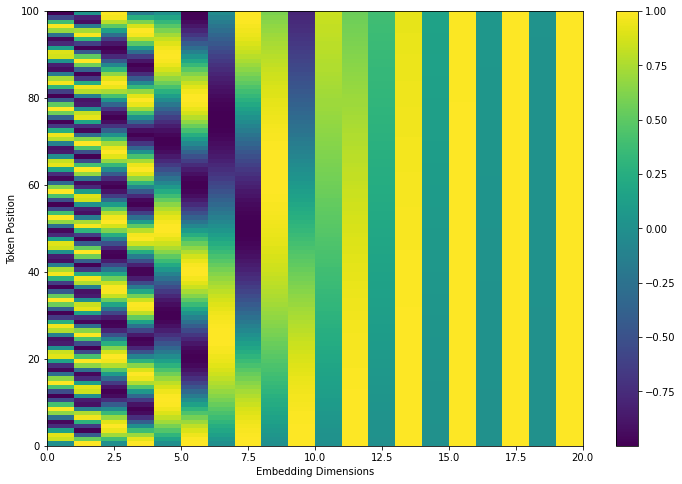

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

pe = PositionalEncoding(20, 0)
y = pe.forward(torch.zeros(1, 100, 20))

plt.figure(figsize=(12,8))
plt.pcolormesh(y[0], cmap='viridis')
plt.xlabel('Embedding Dimensions')
plt.ylabel('Token Position')
plt.colorbar()
plt.show()
     

In [31]:
def make_model(
    src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1
):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab),
    )

    # This was important from their code.
    # Initialize parameters with Glorot / fan_avg.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

In [32]:
# test example
test_model = make_model(11, 11, 2)
test_model.eval()
src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
src_mask = torch.ones(1, 1, 10)
memory = test_model.encode(src, src_mask)
ys = torch.zeros(1, 1).type_as(src)
print(f'memory: {memory.shape}')

memory: torch.Size([1, 10, 512])


In [33]:
for i in range(9):
    out = test_model.decode(
        memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
    )
    prob = test_model.generator(out[:, -1])
    _, next_word = torch.max(prob, dim=1)
    next_word = next_word.data[0]
    ys = torch.cat(
        [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
    )

print("Example Untrained Model Prediction:", ys)

Example Untrained Model Prediction: tensor([[0, 4, 8, 8, 8, 8, 8, 9, 4, 5]])


### Example

In [21]:
# !python -m spacy download de_core_news_sm
# !python -m spacy download en_core_web_sm

In [34]:
def load_tokenizers():

    try:
        spacy_de = spacy.load("de_core_news_sm")
    except IOError:
        os.system("python -m spacy download de_core_news_sm")
        spacy_de = spacy.load("de_core_news_sm")

    try:
        spacy_en = spacy.load("en_core_web_sm")
    except IOError:
        os.system("python -m spacy download en_core_web_sm")
        spacy_en = spacy.load("en_core_web_sm")

    return spacy_de, spacy_en

In [35]:
def tokenize(text, tokenizer):
    return [tok.text for tok in tokenizer.tokenizer(text)]


def yield_tokens(data_iter, tokenizer, index):
    for from_to_tuple in data_iter:
        yield tokenizer(from_to_tuple[index])

In [36]:
def build_vocabulary(spacy_de, spacy_en):
    def tokenize_de(text):
        return tokenize(text, spacy_de)

    def tokenize_en(text):
        return tokenize(text, spacy_en)

    print("Building German Vocabulary ...")
    train, val, test = datasets.Multi30k(language_pair=("de", "en"))
    vocab_src = build_vocab_from_iterator(
        yield_tokens(train + val + test, tokenize_de, index=0),
        min_freq=2,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )

    print("Building English Vocabulary ...")
    train, val, test = datasets.Multi30k(language_pair=("de", "en"))
    vocab_tgt = build_vocab_from_iterator(
        yield_tokens(train + val + test, tokenize_en, index=1),
        min_freq=2,
        specials=["<s>", "</s>", "<blank>", "<unk>"],
    )

    vocab_src.set_default_index(vocab_src["<unk>"])
    vocab_tgt.set_default_index(vocab_tgt["<unk>"])

    return vocab_src, vocab_tgt


def load_vocab(spacy_de, spacy_en):
    if not exists("vocab.pt"):
        vocab_src, vocab_tgt = build_vocabulary(spacy_de, spacy_en)
        torch.save((vocab_src, vocab_tgt), "vocab.pt")
    else:
        vocab_src, vocab_tgt = torch.load("vocab.pt")
    print("Finished.\nVocabulary sizes:")
    print(len(vocab_src))
    print(len(vocab_tgt))
    return vocab_src, vocab_tgt

In [37]:
# build vocabulary
spacy_de, spacy_en = load_tokenizers()
vocab_src, vocab_tgt = load_vocab(spacy_de, spacy_en)
print(f'Some words in vocab: {vocab_tgt.get_itos()[:20]}')

Finished.
Vocabulary sizes:
8316
6385
Some words in vocab: ['<s>', '</s>', '<blank>', '<unk>', 'a', '\n', '.', 'A', 'in', 'the', 'on', 'is', 'and', 'man', 'of', 'with', ',', 'woman', 'are', 'to']


In [38]:
# example of tokenize some english words
vocab_tgt(tokenize("the on man with of woman", spacy_en))

[9, 10, 13, 15, 14, 17]

In [39]:
# example of pad
a = torch.tensor([1,2,3,4,5,6,7])
print(f'original sequence: {a}')

# pad使用 pad(input, (padding_left,padding_right), value)
# 当长度超过当前sequence的长度会用value进行padding，当长度小于当前sequence长度时，将会截断当前sequence。

print(f'Add 3 external token to a {pad(a,(0,3),value=0)}')
print(f'truncate the sequence a  {pad(a,(0,-3),value=0)}')

original sequence: tensor([1, 2, 3, 4, 5, 6, 7])
Add 3 external token to a tensor([1, 2, 3, 4, 5, 6, 7, 0, 0, 0])
truncate the sequence a  tensor([1, 2, 3, 4])


### Batch
分批处理对速度非常重要。我们希望有非常均匀的批处理，并将填充量降到最低。要做到这一点，我们必须在默认的Torchtext批处理方面做一些改动。这段代码对他们的默认批处理进行了修补，以确保我们在足够多的句子上进行搜索以找到紧凑的批次。

In [40]:
def collate_batch(
    batch,
    src_pipeline,  # src tokenizer tokenize("the on man with of woman", spacy_en)
    tgt_pipeline,
    src_vocab,
    tgt_vocab,
    device,
    max_padding=128,
    pad_id=2,
):
    bs_id = torch.tensor([0], device=device)  # <s> token id
    eos_id = torch.tensor([1], device=device)  # </s> token id
    src_list, tgt_list = [], []
    for (_src, _tgt) in batch:
        processed_src = torch.cat(
            [
                bs_id,
                torch.tensor(
                    src_vocab(src_pipeline(_src)),
                    dtype=torch.int64,
                    device=device,
                ),
                eos_id,
            ],
            0,
        )
        processed_tgt = torch.cat(
            [
                bs_id,
                torch.tensor(
                    tgt_vocab(tgt_pipeline(_tgt)),
                    dtype=torch.int64,
                    device=device,
                ),
                eos_id,
            ],
            0,
        )
        src_list.append(
            # 做padding让同一批次的长度一致
            pad(
                processed_src,
                (
                    0,
                    max_padding - len(processed_src),
                ),
                value=pad_id,
            )
        )
        tgt_list.append(
            pad(
                processed_tgt,
                (0, max_padding - len(processed_tgt)),
                value=pad_id,
            )
        )

    src = torch.stack(src_list)
    tgt = torch.stack(tgt_list)
    return (src, tgt)

In [41]:
def create_dataloaders(
    device,
    vocab_src,
    vocab_tgt,
    spacy_de,
    spacy_en,
    batch_size=12000,
    max_padding=128,
):
    def tokenize_de(text):
        return tokenize(text, spacy_de)

    def tokenize_en(text):
        return tokenize(text, spacy_en)

    def collate_fn(batch):
        return collate_batch(
            batch,
            tokenize_de,
            tokenize_en,
            vocab_src,
            vocab_tgt,
            device,
            max_padding=max_padding,
            pad_id=vocab_src.get_stoi()["<blank>"],
        )

    train_iter, valid_iter, test_iter = datasets.Multi30k(language_pair=("de", "en"))

    train_iter_map = to_map_style_dataset(train_iter)

    valid_iter_map = to_map_style_dataset(valid_iter)


    train_dataloader = DataLoader(
        train_iter_map,
        batch_size=batch_size,
        shuffle = True,
        collate_fn=collate_fn,
    )
    valid_dataloader = DataLoader(
        valid_iter_map,
        batch_size=batch_size,
        shuffle = True,
        collate_fn=collate_fn,
    )
    return train_dataloader, valid_dataloader

In [42]:
device = torch.device("cpu")
# torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_exp ,text_exp = create_dataloaders(device, vocab_src, vocab_tgt, spacy_de, spacy_en, batch_size=2, max_padding=128)
print(f'Size of one batch: {next(iter(text_exp))[0].shape}')

Size of one batch: torch.Size([2, 128])


In [43]:
# 需要对相应的src, tgt生成mask,主要针对于进行了padding的序列。

class Batch:
    """Object for holding a batch of data with mask during training."""

    def __init__(self, src, tgt=None, pad=2):  # 2 = <blank>
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if tgt is not None:
            self.tgt = tgt[:, :-1]  # decoder的输入（即期望输出除了最后一个token以外的部分)
            self.tgt_y = tgt[:, 1:]  # decoder的期望输出（trg基础上再删去句子起始符）
            self.tgt_mask = self.make_std_mask(self.tgt, pad)
            self.ntokens = (self.tgt_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(
            tgt_mask.data
        )
        return tgt_mask

In [44]:
# show some example
pad_idx = vocab_tgt["<blank>"]
batch = Batch(next(iter(text_exp))[0], next(iter(text_exp))[1], pad_idx)
print(batch.src_mask.shape)
print(batch.tgt_mask.shape)

torch.Size([2, 1, 128])
torch.Size([2, 127, 127])


In [45]:
# 训练时，每个位置的输入都是ground truth,输出是更新在当前位置
# 因此可以看到batch 中tgt和tgt_y是错开一位的。
# 所以在原文中才叫right-shift output
# 训练时采用这种策略可以在一定程度上防止错误累加。
test_model = make_model(src_vocab = len(vocab_src), tgt_vocab = len(vocab_tgt))
print(f'batch.src: {batch.src.shape}, batch.tgt: {batch.tgt.shape}, batch.src_mask: {batch.src_mask.shape}, batch.tgt_mask: {batch.tgt_mask.shape}')
output = test_model(batch.src, batch.tgt, batch.src_mask, batch.tgt_mask)
print(f'output shape: {output.shape}')

batch.src: torch.Size([2, 128]), batch.tgt: torch.Size([2, 127]), batch.src_mask: torch.Size([2, 1, 128]), batch.tgt_mask: torch.Size([2, 127, 127])
output shape: torch.Size([2, 127, 512])
